In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
HLA_alleles = data_tools.load_HLA_data()

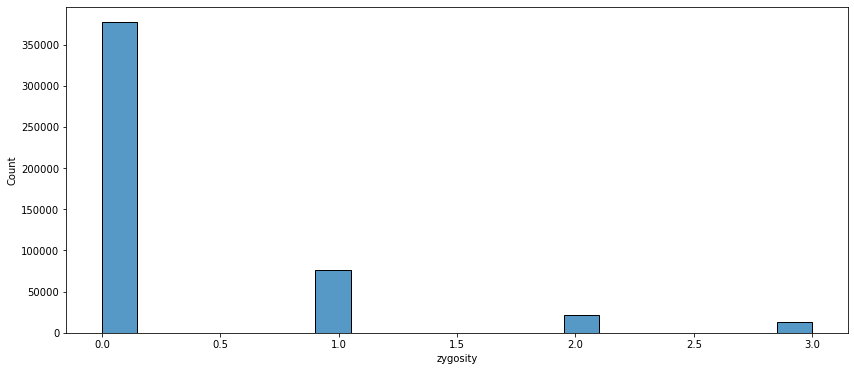

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(HLA_alleles["zygosity"], ax=ax)

# Add Grantham Distance

In [7]:
def calculate_effective_zygosity(HLA_alleles: pd.DataFrame, class_I_allele_map, grantham_distance):
    """ test"""
    
    all_alleles = list(class_I_allele_map.HLA_allele_AA_mapping.keys())
    effectively_unique_alleles = [all_alleles[0]]
    mapping_alleles = {}

    i = 0
    for allele in all_alleles[1:]:
        for unique_allele in effectively_unique_alleles:
            distance = grantham_distance.sequence_group_distance(class_I_allele_map._map([allele, unique_allele]))
            i += 1
            if distance == 0:
                mapping_alleles[allele] = unique_allele
                break
        else:
            effectively_unique_alleles.append(allele)
            
    vector_map_alleles = np.vectorize(lambda s: mapping_alleles.get(s, s))
    effective_HLA_alleles = HLA_alleles[["A1", "A2", "B1", "B2", "C1", "C2"]].apply(vector_map_alleles)
    effective_zygosity = 1 * (effective_HLA_alleles["A1"] == effective_HLA_alleles["A2"])
    effective_zygosity += 1 * (effective_HLA_alleles["B1"] == effective_HLA_alleles["B2"])
    effective_zygosity += 1 * (effective_HLA_alleles["C1"] == effective_HLA_alleles["C2"])
    
    return effective_zygosity


In [8]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)
grantham_distance = gd.GranthamDistance(gd.GRANTHAM_DISTANCE_MATRIX_PATH)

In [10]:
HLA_alleles["effective_zygosity"] = calculate_effective_zygosity(HLA_alleles, class_I_allele_map, grantham_distance)

In [11]:
HLA_alleles

,eid,A1,A2,B1,B2,C1,C2,zygosity,effective_zygosity
0,1000013,A*02:01,A*02:01,B*44:02,B*57:01,C*05:01,C*06:02,1,1
1,1000024,A*01:01,A*01:01,B*07:02,B*08:01,C*07:01,C*07:02,1,1
2,1000036,A*02:01,A*34:02,B*14:01,B*44:02,C*05:01,C*08:02,0,0
3,1000048,A*02:01,A*68:01,B*07:02,B*51:01,C*01:02,C*07:02,0,0
4,1000055,A*01:01,A*03:01,B*13:02,B*57:01,C*06:02,C*06:02,1,1
...,...,...,...,...,...,...,...,...,...
488260,6025313,A*01:01,A*02:01,B*40:01,B*44:02,C*03:04,C*05:01,0,0
488261,6025324,A*01:01,A*01:01,B*08:01,B*57:01,C*06:02,C*07:01,1,1
488262,6025348,A*24:02,A*24:02,B*15:01,B*51:01,C*02:02,C*03:03,1,1
488263,6025355,A*02:01,A*03:01,B*15:01,B*44:02,C*03:04,C*05:01,0,0


In [12]:
allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
if "grantham_divergence" not in HLA_alleles.columns:
    sequences = HLA_alleles[allele_columns].apply(class_I_allele_map._map, axis=1)
    distances = []
    for sequence in tqdm(sequences, unit=" sequence"):
        distances.append(grantham_distance.sequence_group_distance(sequence))

    HLA_alleles["grantham_divergence"] = distances
    
    save_path = constants.UK_BIOBANK_HLA_ALLELES_TSV_FULL_PATH
    HLA_alleles.to_csv(save_path, sep='\t', index=False)

  0%|          | 0/488265 [00:00<?, ? sequence/s]

Elapsed time: 0.0370 seconds


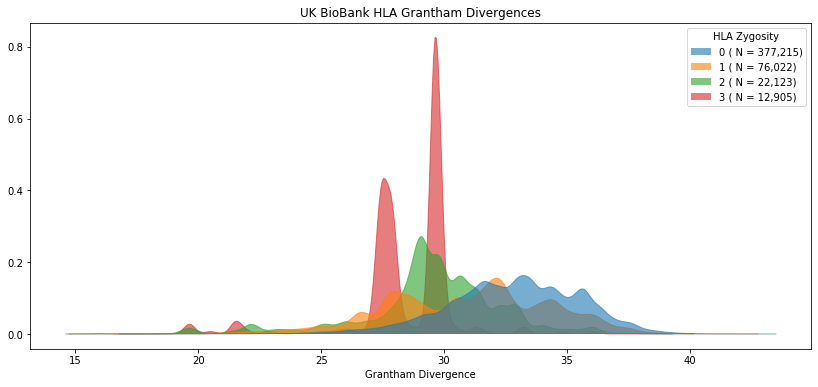

In [13]:
x, hue = "grantham_divergence", "zygosity"

fig, ax = plt.subplots(figsize=(14, 6))
with Timer() as t:
    kde_plot(data=HLA_alleles, x=x, hue=hue, ax=ax, bw=.1)

add_plt_labels(ax, x=x)
ax.set_title("UK BioBank HLA Grantham Divergences")
ax.legend(title="HLA Zygosity")

fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("HLA_grantham_divergences.png"), facecolor="#fffffe")

# Person to person variance 

In [14]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)
grantham_distance = gd.GranthamDistance(gd.GRANTHAM_DISTANCE_MATRIX_PATH)

In [46]:
import scipy
from scipy.optimize import linear_sum_assignment

In [69]:
data = HLA_alleles.sample(1000, random_state=1).copy(deep=True)

In [70]:
HLA_allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
HLA_allele_sequence_columns = []
for allele_column in HLA_allele_columns:
    data[f"{allele_column}_sequence"] = data[allele_column].apply(class_I_allele_map._map, None)
    HLA_allele_sequence_columns.append(f"{allele_column}_sequence")

In [71]:
HLA_dict = dict(zip(data["eid"], data[HLA_allele_sequence_columns].values))

In [72]:
ex_p = data["eid"].values[:2]
data.iloc[:2]

,eid,A1,A2,B1,B2,C1,C2,zygosity,effective_zygosity,grantham_divergence,A1_sequence,A2_sequence,B1_sequence,B2_sequence,C1_sequence,C2_sequence
103320,2063362,A*02:01,A*29:02,B*07:02,B*14:01,C*07:02,C*08:02,0,0,30.110417,MYFFAGYEKVHTHDTLYVRYHYTKWVQLYTWY,MYTFAGYQNVQTDNTLYIMYRDTKWVQLYTWY,MYYFSGYNIYQTDSNLYLSYDYTKWEQRYEWY,MYYFSGYNICNTDSNLYLWYNFTKWEQLYTWH,MYDFSGYEKYQADSNLYLRSDSTKLAQLYTWY,MYYFAGYEKYQTDSNLYLRYNFTKWEQRYTWY
195364,3010484,A*23:01,A*24:02,B*15:01,B*37:01,C*03:03,C*03:03,1,1,33.820833,MYSFAGYEKVHTDNIAYLMFHYTKWVQLYTGY,MYSFAGYEKVHTDNIAYLMFHYTKWVQQYTGY,MYYFAGYEISNTYSNLYLRYDSTKWEQWYLWY,MYHFSGYEISNTYDTLYIRSNFTKWVQDYTWY,MYYFAGYEKYQTDSNLYIRYDYTKWEQLYLWY,MYYFAGYEKYQTDSNLYIRYDYTKWEQLYLWY


In [73]:
p1 = HLA_dict[ex_p[0]]
p2 = HLA_dict[ex_p[1]]


def grantham_linkage(p1, p2):
    """"""
    inter_person_distances = np.array([[grantham_distance.sequence_pair_distance(seq_1, seq_2) for seq_2 in p2]for seq_1 in p1])
    row_ind, col_ind = linear_sum_assignment(inter_person_distances)
    return inter_person_distances[row_ind, col_ind].sum()

grantham_linkage(p1, p1)

0.0

In [74]:
def create_grantham_linkage_map(HLA_dict: dict) -> np.ndarray:
    """"""
    linkage_map = np.zeros((len(HLA_dict), len(HLA_dict)))

    pbar = tqdm(total=len(HLA_dict) ** 2, unit=" grantham linkage", desc="Creating grathan linkage map")
    for i, p1 in enumerate(HLA_dict.values()):
        for j, p2 in enumerate(HLA_dict.values()):
            linkage_map[i, j] = grantham_linkage(p1, p2)
            pbar.update(1)

    pbar.close()
    return linkage_map

linkage_map = create_grantham_linkage_map(HLA_dict)

Creating grathan linkage map:   0%|          | 0/1000000 [00:00<?, ? grantham linkage/s]

C:\Users\Cole\Miniconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Cole\Miniconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


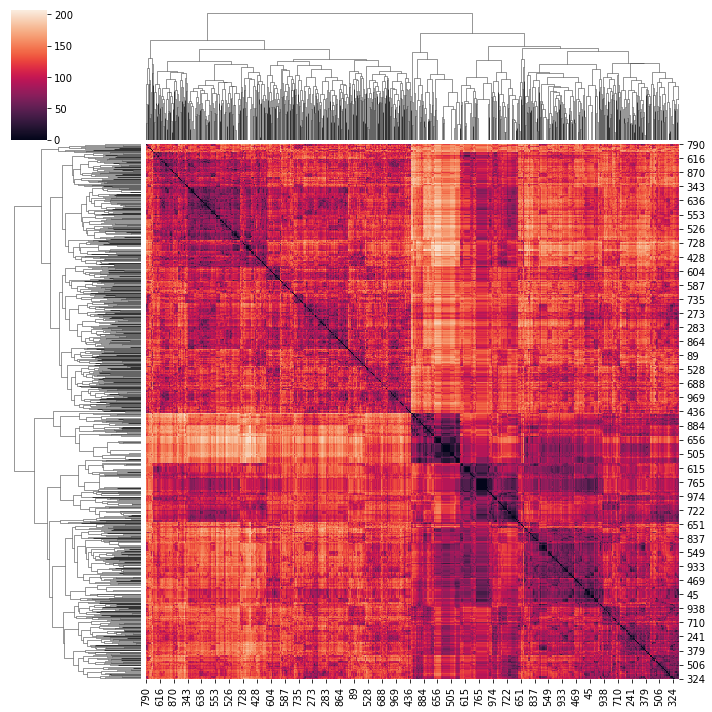

In [75]:
sns.clustermap(linkage_map)